# Convergence

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

In [2]:
os.chdir('../src')

Model definition

In [3]:
from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


In [4]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [5]:
nfe = 200 #
seeds = 2
run_comment = 'nologgerfunc'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\nologgerfunc_200nfe_2seed'

Change the load archives method of the ArchiveLogger class

In [6]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [7]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

In [8]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


In [9]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [10]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.8] * len(model.outcomes), problem)  # [0.05]
print('reference_set', reference_set)
print('reference_set type is', type(reference_set))

reference_set          v0        v1        v2        v3        v4        v5        v6  \
0 -0.585331 -0.512826  0.011481 -0.578277 -0.210124 -0.625810  0.092790   
1  0.038016 -0.058333  0.260364 -0.113002  0.283033 -0.059263  0.218423   

         v7        v8        v9  ...      v223      v224     v225      v226  \
0  0.952882  0.350645  0.632807  ...  0.535201  0.815185  0.60855  0.461293   
1 -0.170923 -0.172600  0.114783  ... -0.451806 -0.078900  0.14283  0.019696   

       v227      v228      v229  Hydropower   Environment  Irrigation  
0 -0.313176  0.020283 -0.853192   14.369320  2.855703e+06    1.122790  
1 -0.242858 -0.027748 -0.092569   16.972215  2.094243e+06    1.362495  

[2 rows x 233 columns]
reference_set type is <class 'pandas.core.frame.DataFrame'>


In [11]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [12]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)

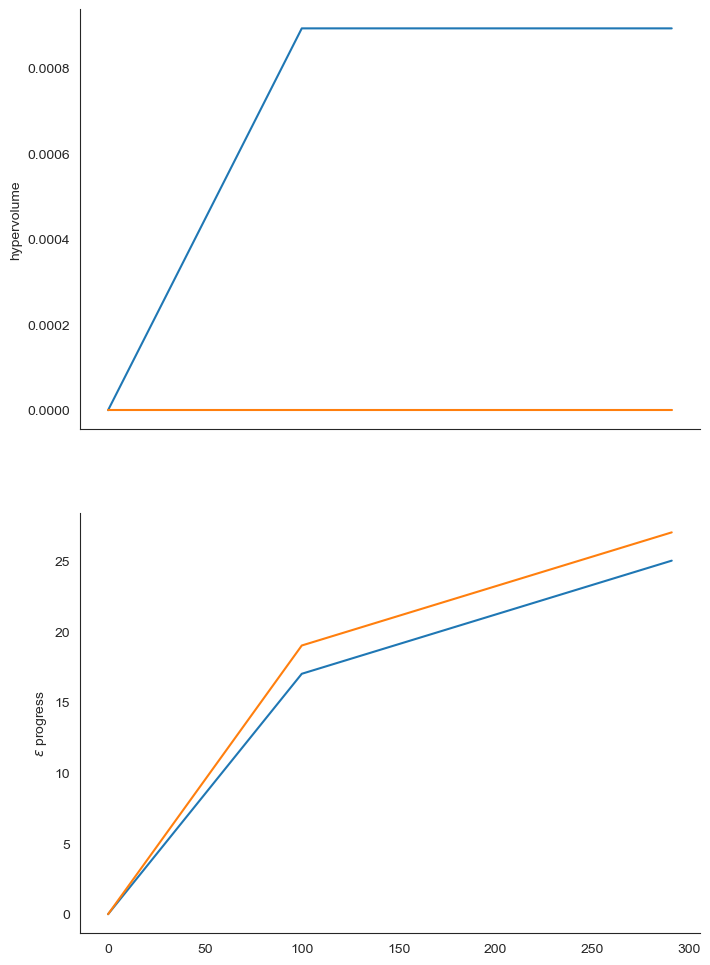

In [13]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()

In [14]:
print(metrics_by_seed)

[   hypervolume  nfe
0     0.000000    0
1     0.000893  100
2     0.000893  291,    hypervolume  nfe
0          0.0    0
1          0.0  100
2          0.0  291]
